In [2]:
import re
import os
import mne
import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mne.viz import plot_compare_evokeds
from mne.time_frequency import tfr_morlet
from mne.channels import find_ch_adjacency
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mne.stats import spatio_temporal_cluster_test, combine_adjacency

import matplotlib.colors as mc


In [3]:
event_map = {'Comment/101':101, 
             'Comment/109':109,
             'Comment/30':30,
             'Comment/40':40,
             'Comment/50':50,
             'Comment/51':51,
             'Comment/52':52,
             'Comment/60':60,
             'Comment/70':70,
             'Comment/80':80,
             'New Segment/':99999}

montage = mne.channels.read_custom_montage('./BC-MR3-64.bvef')

In [4]:
event_id = {'Comment/60':60, 'Comment/70':70, 'Comment/40':40, 'Comment/80':80, 'Comment/51': 51}

In [5]:
# Get active and sham groups from main csv
df = pd.read_csv('../joint/msc_collated_data_20230709.csv')
df = df[["participant_number", "session_type"]].drop_duplicates()

def remove_doubles(x):
    if(x.nunique()==2):
        return 'sham group'
    elif(x.nunique()==1):
        return 'active group'

df["condition"] = df.groupby('participant_number')['session_type'].transform(remove_doubles)
df = df.drop(columns="session_type").drop_duplicates()
df['participant_number'] = df['participant_number'].replace(r'sub-', r'm_', regex=True)

active_ids = df[df.condition=='active group'].participant_number.to_list()
sham_ids = df[df.condition=='sham group'].participant_number.to_list()
# active_ids, sham_ids

In [6]:
# Get list of filenames for each group:
cleaned_dir = './ica_notebooks/cleaned'

active_eeg_files = []
sham_eeg_files = []

for root, dirs, files in os.walk(cleaned_dir):
    for file in files:
        # Actives
        if file.endswith('.vhdr') and any(id in file for id in active_ids):
            active_eeg_files.append(os.path.join(root, file))
        # Sham 
        elif file.endswith('.vhdr') and any(id in file for id in sham_ids):
            sham_eeg_files.append(os.path.join(root, file))

active2bs = []
active2as = []
active1as = []
active1bs = []

sham2bs = []
sham2as = []
sham1as = []
sham1bs = []

# Just look at Posner 2b
for x in active_eeg_files:
    if 'pos2b' in x:
        active2bs.append(x)
    if 'pos1a' in x:
        active1as.append(x)
    if 'pos1b' in x:
        active1bs.append(x)
    if 'pos2a' in x:
        active2as.append(x)
for x in sham_eeg_files:
    if 'pos2b' in x:
        sham2bs.append(x)
    if 'pos1a' in x:
        sham1as.append(x)
    if 'pos1b' in x:
        sham1bs.append(x)
    if 'pos2a' in x:
        sham2as.append(x)

active2bs, sham2bs

(['./ica_notebooks/cleaned/m_09_02/m_09_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_19_02/m_19_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_07_02/m_07_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_03_02/m_03_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_16_02/m_16_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_15_02/m_15_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_20_02/m_20_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_14_02/m_14_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_00_02/m_00_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_10_02/m_10_02_pos2b.vhdr'],
 ['./ica_notebooks/cleaned/m_08_02/m_08_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_18_02/m_18_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_17_02/m_17_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_13_02/m_13_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_02_02/m_02_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_12_02/m_12_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_01_02/m_01_02_pos2b.vhdr',
  './ica_notebooks/cleaned/m_05_02/m_05_02_pos2

In [7]:
all_pos = active2bs+active1as+active2as+active1bs+sham2as+sham2bs+sham1as+sham2bs

In [8]:
all2s = active2bs+sham2bs+active2as+sham2as

In [21]:
# Define the frequency bands of interest
freqs = np.logspace(*np.log10([3, 30]), num=8)  # alpha to gamma frequencies
# freqs = np.arange(7, 20, 2)
n_cycles = freqs / 2.  # different number of cycle per frequency

def process_group(file_names, focal_event):
    epochs_list = list()
    powers = list()
    for file in file_names:
        # Load raw
        raw = mne.io.read_raw(file, preload=True)
        print('dropping channel');raw.drop_channels('ECG')
        # Filter ?
        filt_raw = raw.copy().filter(l_freq=1.0, h_freq=30)
        # Events
        events, event_id = mne.events_from_annotations(raw, event_map) # get events
        # Re-reference
        # avg_ref = raw.copy().set_eeg_reference(ref_channels="average")
        # Get epochs
        reject_crit = dict(
            eeg=1000e-6,
        )
        epochs = mne.Epochs(raw=raw, 
                            events=events, 
                            event_id=focal_event, 
                            detrend=0, 
                            tmin=0, 
                            tmax=1, 
                            # baseline=(-0.5, 0),
                            baseline=(0, None),
                            preload=True,
                            reject=reject_crit,
                            picks=roi_picks,
                            event_repeated='drop')

        epochs.set_montage(montage)
        # test_epochs.plot(events=test_events)
        power = mne.time_frequency.tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=3, n_jobs=1) # get tfr_morlet
        power.info.set_montage(montage) # set_montage
        powers.append(power)
        epochs_list.append(epochs)
        # epochs.plot_drop_log()
    return powers, epochs_list

In [10]:
# roi_picks = ["P7", "P5", "P3", "P1", "Pz", "P2", "P4", "P6", "P8", "PO7", "PO3", "POz", "PO4", "PO8", "O1", "O2", "Oz", "POz"]
roi_picks = ["P2", "P4", "P6", "P8", "PO8", "PO4", "O2", "CP6", "CP4", "CP2", "P7", "P5", "P3", "P1", "PO7", "PO3", "O1", "CP5", "CP3", "CP1", "POz", "Oz", "CPz"]
# roi_picks = ["P7", "P5", "P3", "P1", "Pz", "PO7", "PO3", "POz", "O1", "Oz", "POz"]
# roi_picks = ["PO7", "P7", "P3"]
# roi_picks = ["PO3"]

In [12]:
sham_2b_pow, sham_2b_epochs = process_group(sham2bs, event_id)

Extracting parameters from ./ica_notebooks/cleaned/m_08_02/m_08_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 508821  =      0.000 ...   508.821 secs...
dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
207 matching events found


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


ValueError: Baseline interval [-0.5, 0.0] s is outside of epochs data [0.0, 0.03] s. Epochs were probably cropped.

In [22]:
active_2b_pow, active_2b_epochs = process_group(active2bs, event_id)

Extracting parameters from ./ica_notebooks/cleaned/m_09_02/m_09_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 516619  =      0.000 ...   516.619 secs...
dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
203 matching events found
Setting baseline interval to [0.0, 1.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 203 events and 1001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/2306435452.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_19_02/m_19_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 686119  =      0.000 ...   686.119 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/2306435452.py:39: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
278 matching events found
Setting baseline interval to [0.0, 1.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 278 events and 1001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/2306435452.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_07_02/m_07_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 678635  =      0.000 ...   678.635 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/2306435452.py:39: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
276 matching events found
Setting baseline interval to [0.0, 1.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 276 events and 1001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/2306435452.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_03_02/m_03_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 696262  =      0.000 ...   696.262 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/2306435452.py:39: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
281 matching events found
Setting baseline interval to [0.0, 1.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 281 events and 1001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/2306435452.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_16_02/m_16_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 700376  =      0.000 ...   700.376 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/2306435452.py:39: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
274 matching events found
Setting baseline interval to [0.0, 1.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 274 events and 1001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/2306435452.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_15_02/m_15_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 687590  =      0.000 ...   687.590 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/2306435452.py:39: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
267 matching events found
Setting baseline interval to [0.0, 1.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 267 events and 1001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/2306435452.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_20_02/m_20_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 507628  =      0.000 ...   507.628 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/2306435452.py:39: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
210 matching events found
Setting baseline interval to [0.0, 1.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 210 events and 1001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/2306435452.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_14_02/m_14_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667933  =      0.000 ...   667.933 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/2306435452.py:39: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
260 matching events found
Setting baseline interval to [0.0, 1.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 260 events and 1001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/2306435452.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_00_02/m_00_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 679689  =      0.000 ...   679.689 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/2306435452.py:39: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
274 matching events found
Setting baseline interval to [0.0, 1.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 274 events and 1001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/2306435452.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Extracting parameters from ./ica_notebooks/cleaned/m_10_02/m_10_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668899  =      0.000 ...   668.899 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/2306435452.py:39: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
Not setting metadata
263 matching events found
Setting baseline interval to [0.0, 1.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 263 events and 1001 original time points ...
    Rejecting  epoch based on EEG : ['CP5']
1 bad epochs dropped


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/2306435452.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/2306435452.py:39: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  power.info.set_montage(montage) # set_montage


# TEST

In [24]:
raw_ = mne.io.read_raw('./ica_notebooks/cleaned/m_00_01/m_00_01_pos1a.vhdr', preload=True)
# raw.filter(1, 30)
# events = mne.events_from_annotations(raw_, event_map)

picks=mne.pick_types(raw_.info, eeg=True, eog=True)

epochs = mne.concatenate_epochs(active_2b_epochs) #.pick_channels(roi_picks)

epochs.set_montage(montage)
# epochs.drop_channels('ECG')
epochs.equalize_event_counts(event_id)
X = [epochs[event_name].get_data() for event_name in event_id]
X = [np.transpose(x, (0, 2, 1)) for x in X]

Extracting parameters from ./ica_notebooks/cleaned/m_00_01/m_00_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 685731  =      0.000 ...   685.731 secs...
Not setting metadata
2585 matching events found
Applying baseline correction (mode: mean)


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/3752867595.py:7: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs(active_2b_epochs) #.pick_channels(roi_picks)
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_948/3752867595.py:9: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Dropped 1020 epochs: 0, 11, 15, 19, 24, 27, 30, 32, 33, 36, 40, 42, 43, 45, 47, 48, 50, 52, 53, 56, 60, 62, 63, 65, 66, 68, 69, 70, 71, 72, 74, 75, 76, 80, 82, 87, 89, 90, 91, 92, 93, 95, 96, 98, 99, 101, 102, 104, 105, 107, 108, 110, 111, 113, 117, 119, 126, 128, 133, 134, 136, 137, 139, 140, 142, 143, 145, 146, 154, 156, 158, 159, 161, 162, 167, 169, 170, 172, 177, 178, 183, 185, 187, 188, 190, 194, 196, 197, 199, 200, 202, 203, 205, 206, 208, 209, 211, 212, 223, 231, 235, 246, 249, 251, 258, 260, 261, 265, 268, 270, 277, 285, 290, 292, 293, 295, 297, 298, 300, 301, 303, 304, 306, 307, 309, 313, 315, 317, 318, 320, 322, 323, 328, 329, 331, 332, 334, 335, 337, 338, 340, 342, 355, 357, 358, 360, 361, 363, 364, 369, 371, 373, 374, 376, 377, 379, 380, 388, 392, 394, 395, 400, 401, 403, 404, 406, 407, 409, 410, 414, 416, 422, 424, 425, 427, 428, 430, 431, 433, 434, 436, 438, 439, 441, 448, 450, 451, 453, 454, 456, 464, 465, 467, 469, 470, 478, 480, 481, 483, 484, 486, 487, 489, 493, 501, 

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 23


<class 'scipy.sparse._csr.csr_matrix'>


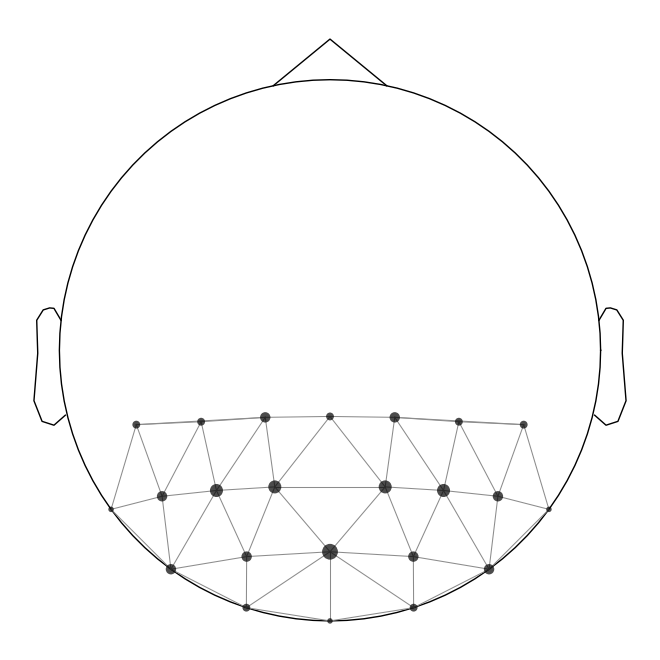

In [25]:
adjacency, ch_names = find_ch_adjacency(epochs.info, ch_type="eeg")

print(type(adjacency))  # it's a sparse matrix!

mne.viz.plot_ch_adjacency(epochs.info, adjacency, ch_names)

plt.show()

In [26]:
event_id_test = {'Comment/60':60, 'Comment/70': 70}

In [27]:
# We are running an F test, so we look at the upper tail
# see also: https://stats.stackexchange.com/a/73993
tail = 1

# We want to set a critical test statistic (here: F), to determine when
# clusters are being formed. Using Scipy's percent point function of the F
# distribution, we can conveniently select a threshold that corresponds to
# some alpha level that we arbitrarily pick.
alpha_cluster_forming = 0.05

# For an F test we need the degrees of freedom for the numerator
# (number of conditions - 1) and the denominator (number of observations
# - number of conditions):
n_conditions = len(event_id_test); print(n_conditions)
n_observations = len(X[0]); print(n_observations)
dfn = n_conditions - 1
dfd = n_observations - n_conditions

# Note: we calculate 1 - alpha_cluster_forming to get the critical value
# on the right tail
f_thresh = scipy.stats.f.ppf(1 - alpha_cluster_forming, dfn=dfn, dfd=dfd)

# run the cluster based permutation analysis
cluster_stats = spatio_temporal_cluster_test(
    X,
    n_permutations=100,
    threshold=f_thresh,
    tail=tail,
    # n_jobs=2
    buffer_size=None,
    adjacency=adjacency,
)
F_obs, clusters, p_values, _ = cluster_stats

2
313
stat_fun(H1): min=0.005313 max=16.805801
Running initial clustering …
Found 60 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

In [28]:
# We subselect clusters that we consider significant at an arbitrarily
# picked alpha level: "p_accept".
# NOTE: remember the caveats with respect to "significant" clusters that
# we mentioned in the introduction of this tutorial!
p_accept = 0.05
good_cluster_inds = np.where(p_values < p_accept)[0]

print('good cluster inds:', (p_values))

# configure variables for visualization
colors = {"Comment/60": "crimson", "Comment/70": "steelblue"}
# linestyles = {"Comment/60": "-", "Comment/70": "--"}

# organize data for plotting
evokeds = {cond: epochs[cond].average() for cond in event_id_test}

# loop over clusters
for i_clu, clu_idx in enumerate(good_cluster_inds):
    # unpack cluster information, get unique indices
    time_inds, space_inds = np.squeeze(clusters[clu_idx])
    ch_inds = np.unique(space_inds)
    time_inds = np.unique(time_inds)

    # get topography for F stat
    f_map = F_obs[time_inds, ...].mean(axis=0)

    # get signals at the sensors contributing to the cluster
    sig_times = epochs.times[time_inds]

    # create spatial mask
    mask = np.zeros((f_map.shape[0], 1), dtype=bool)
    mask[ch_inds, :] = True

    # initialize figure
    fig, ax_topo = plt.subplots(1, 1, figsize=(10, 3))

    # plot average test statistic and mark significant sensors
    f_evoked = mne.EvokedArray(f_map[:, np.newaxis], epochs.info, tmin=0)
    f_evoked.plot_topomap(
        times=0,
        mask=mask,
        axes=ax_topo,
        cmap="Reds",
        vlim=(np.min, np.max),
        show=False,
        colorbar=False,
        mask_params=dict(markersize=10),
    )
    image = ax_topo.images[0]

    # remove the title that would otherwise say "0.000 s"
    ax_topo.set_title("")

    # create additional axes (for ERF and colorbar)
    divider = make_axes_locatable(ax_topo)

    # add axes for colorbar
    ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_topo.set_xlabel(
        "Averaged F-map ({:0.3f} - {:0.3f} s)".format(*sig_times[[0, -1]])
    )

    # add new axis for time courses and plot time courses
    ax_signals = divider.append_axes("right", size="300%", pad=1.2)
    title = "Cluster #{0}, {1} sensor".format(i_clu + 1, len(ch_inds))
    if len(ch_inds) > 1:
        title += "s (mean)"
    plot_compare_evokeds(
        evokeds,
        title=title,
        picks=ch_inds,
        axes=ax_signals,
        colors=colors,
        # linestyles=linestyles,
        show=False,
        split_legend=True,
        truncate_yaxis="auto",
    )

    # plot temporal cluster extent
    ymin, ymax = ax_signals.get_ylim()
    ax_signals.fill_betweenx(
        (ymin, ymax), sig_times[0], sig_times[-1], color="orange", alpha=0.3
    )

    # clean up viz
    mne.viz.tight_layout(fig=fig)
    fig.subplots_adjust(bottom=0.05)
    plt.show()

good cluster inds: [1.   0.01 0.86 0.95 0.99 0.99 0.99 1.   1.   1.   0.99 0.99 0.97 0.99
 0.95 0.99 0.91 0.66 1.   0.03 1.   0.99 0.99 0.67 0.54 0.07 0.07 0.99
 1.   0.6  0.99 0.99 0.08 0.83 0.99 0.82 0.99 0.99 0.95 0.95 0.31 0.07
 0.87 0.92 1.   0.31 0.96 1.   1.   0.99 1.   0.82 0.99 1.   0.99 1.
 0.88 0.99 1.   0.96]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


# ON neurofeedback data?

# Cluster stats left versus right lateralisation during cue

In [12]:
# Define the frequency bands of interest
freqs = np.logspace(*np.log10([3, 30]), num=8)  # alpha to gamma frequencies
# freqs = np.arange(7, 20, 2)
n_cycles = freqs / 2.  # different number of cycle per frequency
all2bs = active2bs+sham2bs

In [13]:
def gather_epochs(file_names, event_ids={'Comment/60':60, 'Comment/70':70}):
    epochs_list = []
    for file in file_names:
        # Load raw
        raw = mne.io.read_raw(file, preload=True)
        print('dropping channel');raw.drop_channels('ECG')
        # Filter ?
        filt_raw = raw.copy().filter(l_freq=3, h_freq=20)
        # Events
        events, event_id = mne.events_from_annotations(filt_raw, event_map) # get events
        # Re-reference
        avg_ref = raw.copy().set_eeg_reference(ref_channels="average")
        # Epoch rejection rule
        reject_criteria=dict(eeg=500e6)
        # Get epochs
        epochs = mne.Epochs(raw=avg_ref, 
                            events=events, 
                            event_id=event_ids, 
                            reject=reject_criteria,
                            detrend=1, 
                            tmin=-0.5, 
                            tmax=2, 
                            # baseline=(-0.5, 0),
                            baseline=(0, None),
                            preload=True,
                            # picks=picks,
                            event_repeated='drop')

        epochs.set_montage(montage)
        epochs_list.append([epochs, file])
        del raw
    return epochs_list

In [13]:
active2b_epochs = gather_epochs(active2bs)

Extracting parameters from ./ica_notebooks/cleaned/m_09_02/m_09_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 516619  =      0.000 ...   516.619 secs...
dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
55 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 55 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_19_02/m_19_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 686119  =      0.000 ...   686.119 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
64 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 64 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_02/m_07_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 678635  =      0.000 ...   678.635 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
62 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 62 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_02/m_03_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 696262  =      0.000 ...   696.262 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
62 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 62 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_16_02/m_16_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 700376  =      0.000 ...   700.376 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
73 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 73 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_02/m_15_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 687590  =      0.000 ...   687.590 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
65 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 65 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_02/m_20_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 507628  =      0.000 ...   507.628 secs...
dropping channel

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
53 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 1501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_02/m_14_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667933  =      0.000 ...   667.933 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
68 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 68 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_02/m_00_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 679689  =      0.000 ...   679.689 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
71 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 71 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_02/m_10_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668899  =      0.000 ...   668.899 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
64 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 64 events and 1501 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


In [16]:
all2b_epochs=gather_epochs(all2bs)

Extracting parameters from ./ica_notebooks/cleaned/m_09_02/m_09_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 516619  =      0.000 ...   516.619 secs...
dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
55 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 55 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_19_02/m_19_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 686119  =      0.000 ...   686.119 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
64 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 64 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_02/m_07_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 678635  =      0.000 ...   678.635 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
62 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 62 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_02/m_03_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 696262  =      0.000 ...   696.262 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
62 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 62 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_16_02/m_16_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 700376  =      0.000 ...   700.376 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
73 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 73 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_02/m_15_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 687590  =      0.000 ...   687.590 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
65 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 65 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_02/m_20_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 507628  =      0.000 ...   507.628 secs...
dropping channel

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
53 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 1501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_02/m_14_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667933  =      0.000 ...   667.933 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
68 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 68 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_02/m_00_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 679689  =      0.000 ...   679.689 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
71 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 71 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_02/m_10_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668899  =      0.000 ...   668.899 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
64 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 64 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_02/m_08_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 508821  =      0.000 ...   508.821 secs...
dropping channel

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
54 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 54 events and 1501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_02/m_18_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 660150  =      0.000 ...   660.150 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_02/m_17_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 699563  =      0.000 ...   699.563 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
55 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 55 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_02/m_13_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668631  =      0.000 ...   668.631 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
70 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 70 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_02/m_02_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667422  =      0.000 ...   667.422 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
68 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 68 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_02/m_12_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 675910  =      0.000 ...   675.910 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
75 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 75 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_02/m_01_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 690070  =      0.000 ...   690.070 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
63 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 63 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_02/m_05_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 706851  =      0.000 ...   706.851 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
57 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 57 events and 1501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_02/m_04_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 683430  =      0.000 ...   683.430 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
79 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 79 events and 1501 original time points ...
0 bad epochs dropped


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_1076/2618196301.py:28: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


In [189]:
decim = 4
freqs = np.arange(7, 30, 8)  # define frequencies of interest
n_cycles = freqs / freqs[0]

twobepochs=mne.concatenate_epochs(all2b_epochs)

epochs_power = list()
for condition in [twobepochs[k] for k in ("Comment/60", "Comment/70")]:
    this_tfr = tfr_morlet(
        condition,
        freqs,
        n_cycles=n_cycles,
        decim=decim,
        average=False,
        return_itc=False,
    )
    this_tfr.apply_baseline(mode="ratio", baseline=(None, 0))
    epochs_power.append(this_tfr.data)

# transpose again to (epochs, frequencies, times, channels)
X = [np.transpose(x, (0, 2, 3, 1)) for x in epochs_power]

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_73311/164970980.py:5: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  twobepochs=mne.concatenate_epochs(all2b_epochs)


Not setting metadata
1206 matching events found
Applying baseline correction (mode: mean)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:   14.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: ratio)


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:   14.3s finished


In [199]:
# our data at each observation is of shape frequencies × times × channels
tfr_adjacency = combine_adjacency(len(freqs), len(this_tfr.times), adjacency)

In [1]:
# This time we don't calculate a threshold based on the F distribution.
# We might as well select an arbitrary threshold for cluster forming
tfr_threshold = 15.0

# run cluster based permutation analysis
cluster_stats = spatio_temporal_cluster_test(
    X,
    n_permutations=1000,
    threshold=tfr_threshold,
    tail=1,
    n_jobs=None,
    buffer_size=None,
    adjacency=tfr_adjacency,
)

NameError: name 'spatio_temporal_cluster_test' is not defined

# Alpha comparions during posner cueing

Looking at all participants...

In [46]:
alpha_roi = ["P7", "P5", "P3", "P1", "Pz","P2", "P4", "P6", "P8","PO8", "PO4", "PO7", "PO3", "POz", "O1","O2", "Oz"]

In [177]:
def calc_avg(tf_data):
    return np.mean(tf_data.data, axis=None)


# Alpha comparisons

In [188]:
all2bs

['./ica_notebooks/cleaned/m_09_02/m_09_02_pos2b.vhdr',
 './ica_notebooks/cleaned/m_19_02/m_19_02_pos2b.vhdr',
 './ica_notebooks/cleaned/m_07_02/m_07_02_pos2b.vhdr',
 './ica_notebooks/cleaned/m_03_02/m_03_02_pos2b.vhdr',
 './ica_notebooks/cleaned/m_16_02/m_16_02_pos2b.vhdr',
 './ica_notebooks/cleaned/m_15_02/m_15_02_pos2b.vhdr',
 './ica_notebooks/cleaned/m_20_02/m_20_02_pos2b.vhdr',
 './ica_notebooks/cleaned/m_14_02/m_14_02_pos2b.vhdr',
 './ica_notebooks/cleaned/m_00_02/m_00_02_pos2b.vhdr',
 './ica_notebooks/cleaned/m_10_02/m_10_02_pos2b.vhdr',
 './ica_notebooks/cleaned/m_08_02/m_08_02_pos2b.vhdr',
 './ica_notebooks/cleaned/m_18_02/m_18_02_pos2b.vhdr',
 './ica_notebooks/cleaned/m_17_02/m_17_02_pos2b.vhdr',
 './ica_notebooks/cleaned/m_13_02/m_13_02_pos2b.vhdr',
 './ica_notebooks/cleaned/m_02_02/m_02_02_pos2b.vhdr',
 './ica_notebooks/cleaned/m_12_02/m_12_02_pos2b.vhdr',
 './ica_notebooks/cleaned/m_01_02/m_01_02_pos2b.vhdr',
 './ica_notebooks/cleaned/m_05_02/m_05_02_pos2b.vhdr',
 './ica_no

In [171]:
def get_subject_tfr(ep, roi, freqs):
    """Get the mean power over a set of epochs.

    Args:
        ep (mne.Epochs): Epochs in question.
        roi (list): List of strings corresponding to channel picks which are the region of interest.
        freqs (list): List of integer frequency 
    
    Returns:
        float: The mean power for the set of epochs and frequencies.
    """
    tfr_ting = mne.time_frequency.tfr_multitaper(ep, freqs=freqs, n_cycles=freqs/2, picks = roi, return_itc=False)
    power_mean = np.mean(tfr_ting.data, axis=None)
    return power_mean

def get_psd_power_normed(ep, roi):
    spectrum = ep.compute_psd('welch', fmin=8, fmax=12, tmin=0, tmax=1, picks=roi)
    alpha =  spectrum.to_data_frame().drop(columns=['condition', 'epoch', 'freq']).melt().value
    mean_alpha =  spectrum.to_data_frame().drop(columns=['condition', 'epoch', 'freq']).melt().value.mean()
    std_alpha = spectrum.to_data_frame().drop(columns=['condition', 'epoch', 'freq']).melt().value.std()
    centered_alpha_power = alpha - mean_alpha
    normed_alpha_power = centered_alpha_power / std_alpha
    return normed_alpha_power.mean()

def get_psd_power(ep, roi, freqs):
    spectrum = ep.compute_psd('welch', fmin=8, fmax=12, tmin=0, tmax=1, picks=roi)
    return spectrum.to_data_frame().drop(columns=['condition', 'epoch', 'freq']).melt().value.mean()

def create_power_table(file_names):
    """Create a table of powers for each eeg file in the list supplied.
    """
    output = {
        'Participant':[],
        'ROI':[],
        'Cue':[],
        'Session':[],
        'Power':[]
    }

    regions = {
        'left occipital' : ["O1"],
        'right occipital' : ["O2"],
        'left parietal-occipital':["PO7", "PO3"],
        'right parietal-occipital':["PO8", "PO4"],
        'left parietal' : ["P7", "P5", "P3", "P1"],
        'right parietal' : ["P2", "P4", "P6", "P8"],
        'right O, PO and CP' : ["P2", "P4", "P6", "P8", "PO8", "PO4", "O2", "CP6", "CP4", "CP2"],
        'left O, PO and CP' : ["P7", "P5", "P3", "P1", "PO7", "PO3", "O1", "CP5", "CP3", "CP1"]
    }

    cue_key = [
        ['left',60],
        ['right',70],
        # ['centre',80]
    ]

    freq_roi = {'Alpha': np.arange(8, 12, 1)}

    for i in range(len(cue_key)):
        cue_epochs = gather_epochs(file_names, cue_key[i][1])
        for key, value in regions.items():
            for sub_epochs in cue_epochs:
                sub_id=sub_epochs[1].strip('/ica_notebooks/cleaned/')
                sub_id=re.search(r"/([^/]*)$", sub_id).group(1)
                sub_id=re.findall(r'm_([^_]*)', sub_id)[0]
                session=re.search(r".*pos(\d)\D.*", sub_epochs[1]).group(1)
                epochs=sub_epochs[0]
                power_mean = get_psd_power_normed(epochs, value)
                output['Participant'].append(sub_id)
                output['ROI'].append(key)
                output['Power'].append(power_mean)
                output['Cue'].append(cue_key[i][0])
                output['Session'].append(session)
    return pd.DataFrame(output)

In [172]:
test_powers = create_power_table(all_pos[:2])
test_powers

Extracting parameters from ./ica_notebooks/cleaned/m_09_02/m_09_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 516619  =      0.000 ...   516.619 secs...
dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_19_02/m_19_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 686119  =      0.000 ...   686.119 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
38 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 2501 original time points ...
0 bad epochs dropped
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Extracting parameters from ./ica_notebooks/cleaned/m_09_02/m_09_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 516619  =      0.000 ...   516.619 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
27 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_19_02/m_19_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 686119  =      0.000 ...   686.119 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
26 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 26 events and 2501 original time points ...
0 bad epochs dropped
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


,Participant,ROI,Cue,Session,Power
0,09,left occipital,left,2,-4.361590e-17
1,19,left occipital,left,2,3.505967e-17
2,09,right occipital,left,2,-1.586033e-16
3,19,right occipital,left,2,-4.674623e-17
4,09,left parietal-occipital,left,2,-7.137148e-17
5,19,left parietal-occipital,left,2,0.000000e+00
6,09,right parietal-occipital,left,2,7.533656e-17
7,19,right parietal-occipital,left,2,-1.168656e-17
8,09,left parietal,left,2,-3.172066e-17
9,19,left parietal,left,2,-1.168656e-17


In [174]:
all_powers = create_power_table(all_pos)

Extracting parameters from ./ica_notebooks/cleaned/m_09_02/m_09_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 516619  =      0.000 ...   516.619 secs...
dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_19_02/m_19_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 686119  =      0.000 ...   686.119 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
38 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_02/m_07_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 678635  =      0.000 ...   678.635 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
34 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 34 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_02/m_03_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 696262  =      0.000 ...   696.262 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
29 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_16_02/m_16_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 700376  =      0.000 ...   700.376 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
36 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_02/m_15_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 687590  =      0.000 ...   687.590 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_02/m_20_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 507628  =      0.000 ...   507.628 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
23 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_02/m_14_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667933  =      0.000 ...   667.933 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
32 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_02/m_00_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 679689  =      0.000 ...   679.689 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
36 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_02/m_10_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668899  =      0.000 ...   668.899 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_11_01/m_11_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 675030  =      0.000 ...   675.030 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
25 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_01/m_15_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 703100  =      0.000 ...   703.100 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_01/m_14_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 687981  =      0.000 ...   687.981 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
34 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 34 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_01/m_20_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 498570  =      0.000 ...   498.570 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
16 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 16 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_01/m_10_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 665561  =      0.000 ...   665.561 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
38 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_01/m_00_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 685731  =      0.000 ...   685.731 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_19_01/m_19_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 605579  =      0.000 ...   605.579 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
31 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_09_01/m_09_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 699340  =      0.000 ...   699.340 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
41 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 41 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_01/m_07_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 686560  =      0.000 ...   686.560 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
29 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_01/m_03_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 667374  =      0.000 ...   667.374 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
22 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 22 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_16_01/m_16_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 676029  =      0.000 ...   676.029 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
44 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 44 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_09_02/m_09_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 516738  =      0.000 ...   516.738 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
23 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_02/m_07_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 703313  =      0.000 ...   703.313 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
38 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_02/m_03_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 667497  =      0.000 ...   667.497 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
43 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 43 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_11_02/m_11_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 675340  =      0.000 ...   675.340 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_02/m_15_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 663436  =      0.000 ...   663.436 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
39 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_02/m_20_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 500248  =      0.000 ...   500.248 secs...
dropping channel

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
23 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_02/m_14_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 516705  =      0.000 ...   516.705 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
23 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_02/m_00_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 675588  =      0.000 ...   675.588 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
29 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_02/m_10_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 667992  =      0.000 ...   667.992 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
42 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 42 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_11_01/m_11_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 685241  =      0.000 ...   685.241 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
34 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 34 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_01/m_15_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 665711  =      0.000 ...   665.711 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_01/m_14_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 686370  =      0.000 ...   686.370 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_01/m_20_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 498009  =      0.000 ...   498.009 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
21 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 21 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_01/m_10_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 667363  =      0.000 ...   667.363 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_01/m_00_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 680309  =      0.000 ...   680.309 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
22 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 22 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_19_01/m_19_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 736370  =      0.000 ...   736.370 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.9s finished


Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_09_01/m_09_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 535139  =      0.000 ...   535.139 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
25 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_01/m_07_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 669191  =      0.000 ...   669.191 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_01/m_03_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 673432  =      0.000 ...   673.432 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
31 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_16_01/m_16_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 667352  =      0.000 ...   667.352 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_02/m_08_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 728771  =      0.000 ...   728.771 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
24 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 24 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_02/m_18_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 668340  =      0.000 ...   668.340 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
32 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_02/m_17_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 675771  =      0.000 ...   675.771 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_02/m_13_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 675770  =      0.000 ...   675.770 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
27 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_02/m_02_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 700777  =      0.000 ...   700.777 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_02/m_12_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 674207  =      0.000 ...   674.207 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
39 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_06_02/m_06_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 690202  =      0.000 ...   690.202 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_02/m_01_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 687606  =      0.000 ...   687.606 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
32 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_02/m_05_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 681642  =      0.000 ...   681.642 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_02/m_04_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 679230  =      0.000 ...   679.230 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
25 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_02/m_08_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 508821  =      0.000 ...   508.821 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
31 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_02/m_18_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 660150  =      0.000 ...   660.150 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
21 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 21 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_02/m_17_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 699563  =      0.000 ...   699.563 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_02/m_13_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668631  =      0.000 ...   668.631 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_02/m_02_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667422  =      0.000 ...   667.422 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
39 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_02/m_12_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 675910  =      0.000 ...   675.910 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
27 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_02/m_01_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 690070  =      0.000 ...   690.070 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_02/m_05_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 706851  =      0.000 ...   706.851 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
29 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_02/m_04_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 683430  =      0.000 ...   683.430 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_01/m_01_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 691051  =      0.000 ...   691.051 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
31 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_01/m_05_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 689190  =      0.000 ...   689.190 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_01/m_04_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 670980  =      0.000 ...   670.980 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_01/m_18_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 663110  =      0.000 ...   663.110 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_01/m_08_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 699450  =      0.000 ...   699.450 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_01/m_17_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 671811  =      0.000 ...   671.811 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    0.6s finished


Not setting metadata
22 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 22 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_01/m_13_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 665210  =      0.000 ...   665.210 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
32 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_01/m_12_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 686230  =      0.000 ...   686.230 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_01/m_02_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 680040  =      0.000 ...   680.040 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_06_01/m_06_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 689061  =      0.000 ...   689.061 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_02/m_08_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 508821  =      0.000 ...   508.821 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
31 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_02/m_18_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 660150  =      0.000 ...   660.150 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
21 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 21 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_02/m_17_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 699563  =      0.000 ...   699.563 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_02/m_13_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668631  =      0.000 ...   668.631 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_02/m_02_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667422  =      0.000 ...   667.422 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
39 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_02/m_12_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 675910  =      0.000 ...   675.910 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
27 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_02/m_01_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 690070  =      0.000 ...   690.070 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_02/m_05_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 706851  =      0.000 ...   706.851 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
29 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_02/m_04_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 683430  =      0.000 ...   683.430 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.00

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective wind

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
27 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_19_02/m_19_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 686119  =      0.000 ...   686.119 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
26 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 26 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_02/m_07_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 678635  =      0.000 ...   678.635 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_02/m_03_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 696262  =      0.000 ...   696.262 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_16_02/m_16_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 700376  =      0.000 ...   700.376 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_02/m_15_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 687590  =      0.000 ...   687.590 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
32 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_02/m_20_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 507628  =      0.000 ...   507.628 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_02/m_14_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667933  =      0.000 ...   667.933 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
36 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_02/m_00_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 679689  =      0.000 ...   679.689 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_02/m_10_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668899  =      0.000 ...   668.899 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
31 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 31 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_11_01/m_11_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 675030  =      0.000 ...   675.030 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
34 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 34 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_01/m_15_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 703100  =      0.000 ...   703.100 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_01/m_14_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 687981  =      0.000 ...   687.981 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
36 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_01/m_20_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 498570  =      0.000 ...   498.570 secs...
dropping channel


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
27 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_01/m_10_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 665561  =      0.000 ...   665.561 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
33 matching events found


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_01/m_00_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 685731  =      0.000 ...   685.731 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_19_01/m_19_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 605579  =      0.000 ...   605.579 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
23 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_09_01/m_09_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 699340  =      0.000 ...   699.340 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
36 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_01/m_07_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 686560  =      0.000 ...   686.560 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
33 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 33 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_01/m_03_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 667374  =      0.000 ...   667.374 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_16_01/m_16_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 676029  =      0.000 ...   676.029 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
39 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 39 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_09_02/m_09_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 516738  =      0.000 ...   516.738 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
26 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 26 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_02/m_07_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 703313  =      0.000 ...   703.313 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
41 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 41 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_02/m_03_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 667497  =      0.000 ...   667.497 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
25 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_11_02/m_11_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 675340  =      0.000 ...   675.340 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_02/m_15_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 663436  =      0.000 ...   663.436 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_02/m_20_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 500248  =      0.000 ...   500.248 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
23 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_02/m_14_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 516705  =      0.000 ...   516.705 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
26 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 26 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_02/m_00_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 675588  =      0.000 ...   675.588 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_02/m_10_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 667992  =      0.000 ...   667.992 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
32 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_11_01/m_11_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 685241  =      0.000 ...   685.241 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
36 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_15_01/m_15_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 665711  =      0.000 ...   665.711 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_14_01/m_14_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 686370  =      0.000 ...   686.370 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_20_01/m_20_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 498009  =      0.000 ...   498.009 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_10_01/m_10_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 667363  =      0.000 ...   667.363 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_00_01/m_00_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 680309  =      0.000 ...   680.309 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_19_01/m_19_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 736370  =      0.000 ...   736.370 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
32 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_09_01/m_09_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 535139  =      0.000 ...   535.139 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
25 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_07_01/m_07_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 669191  =      0.000 ...   669.191 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_03_01/m_03_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 673432  =      0.000 ...   673.432 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
32 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_16_01/m_16_01_pos1b.vhdr...
Setting channel info structure...
Reading 0 ... 667352  =      0.000 ...   667.352 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
29 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_02/m_08_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 728771  =      0.000 ...   728.771 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
38 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_02/m_18_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 668340  =      0.000 ...   668.340 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
36 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_02/m_17_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 675771  =      0.000 ...   675.771 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
32 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 32 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_02/m_13_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 675770  =      0.000 ...   675.770 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
40 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 40 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_02/m_02_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 700777  =      0.000 ...   700.777 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
36 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_02/m_12_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 674207  =      0.000 ...   674.207 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_06_02/m_06_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 690202  =      0.000 ...   690.202 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_02/m_01_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 687606  =      0.000 ...   687.606 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
36 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_02/m_05_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 681642  =      0.000 ...   681.642 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
29 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_02/m_04_02_pos2a.vhdr...
Setting channel info structure...
Reading 0 ... 679230  =      0.000 ...   679.230 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
45 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 45 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_02/m_08_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 508821  =      0.000 ...   508.821 secs...
dropping channel

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
23 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.5s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_02/m_18_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 660150  =      0.000 ...   660.150 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
27 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_02/m_17_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 699563  =      0.000 ...   699.563 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
25 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_02/m_13_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668631  =      0.000 ...   668.631 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_02/m_02_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667422  =      0.000 ...   667.422 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
29 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_02/m_12_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 675910  =      0.000 ...   675.910 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
48 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_02/m_01_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 690070  =      0.000 ...   690.070 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_02/m_05_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 706851  =      0.000 ...   706.851 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_02/m_04_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 683430  =      0.000 ...   683.430 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
42 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 42 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_01/m_01_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 691051  =      0.000 ...   691.051 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_01/m_05_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 689190  =      0.000 ...   689.190 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
27 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_01/m_04_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 670980  =      0.000 ...   670.980 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
25 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_01/m_18_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 663110  =      0.000 ...   663.110 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
34 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 34 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_01/m_08_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 699450  =      0.000 ...   699.450 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
38 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 38 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_01/m_17_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 671811  =      0.000 ...   671.811 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    0.7s finished


Not setting metadata
40 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 40 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_01/m_13_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 665210  =      0.000 ...   665.210 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
36 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 36 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_01/m_12_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 686230  =      0.000 ...   686.230 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
30 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_01/m_02_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 680040  =      0.000 ...   680.040 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_06_01/m_06_01_pos1a.vhdr...
Setting channel info structure...
Reading 0 ... 689061  =      0.000 ...   689.061 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_08_02/m_08_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 508821  =      0.000 ...   508.821 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
23 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 23 events and 2501 original time points ...


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_18_02/m_18_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 660150  =      0.000 ...   660.150 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
27 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 27 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_17_02/m_17_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 699563  =      0.000 ...   699.563 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
25 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 25 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_13_02/m_13_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 668631  =      0.000 ...   668.631 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
37 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 37 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_02_02/m_02_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 667422  =      0.000 ...   667.422 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    1.0s finished


Not setting metadata
29 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 29 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_12_02/m_12_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 675910  =      0.000 ...   675.910 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.8s finished


Not setting metadata
48 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_01_02/m_01_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 690070  =      0.000 ...   690.070 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.9s finished


Not setting metadata
35 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_05_02/m_05_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 706851  =      0.000 ...   706.851 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.7s finished


Not setting metadata
28 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 28 events and 2501 original time points ...
0 bad epochs dropped
Extracting parameters from ./ica_notebooks/cleaned/m_04_02/m_04_02_pos2b.vhdr...
Setting channel info structure...
Reading 0 ... 683430  =      0.000 ...   683.430 secs...


/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


dropping channel
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Used Annotations descriptions: ['Comment/101', 'Comment/109', 'Comment/30', 'Comment/40', 'Comment/50', 'Comment/51', 'Comment/52', 'Comment/60', 'Comment/70', 'Comment/80', 'New Segment/']
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.6s finished


Not setting metadata
42 matching events found
Setting baseline interval to [0.0, 2.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 42 events and 2501 original time points ...
0 bad epochs dropped
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.00

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3628441240.py:29: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  epochs.set_montage(montage)


Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective window size : 1.001 (s)
Effective wind

In [176]:
baseline_powers = pd.read_csv('./baseline_powers.csv')
base_ec_powers = baseline_powers[baseline_powers['baseline type']=='baseline_eo']
base_ec_powers['participant'] = base_ec_powers['participant'].astype(int)
base_ec_powers['session'] = base_ec_powers['session'].astype(int)
base_ec_powers = base_ec_powers.drop(columns=['code', 'baseline', 'baseline type', 'time'])
base_ec_powers.rename(columns={'power': 'baseline_power', 'participant':'Participant', 'session':'Session'}, inplace=True)
base_ec_powers

/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3566996351.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_ec_powers['participant'] = base_ec_powers['participant'].astype(int)
/var/folders/2b/4tnqzv_x3x17pf4q1_n7m8h40000gn/T/ipykernel_15023/3566996351.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_ec_powers['session'] = base_ec_powers['session'].astype(int)


,Participant,Session,ROI,baseline_power
0,0,1,left occipital,-1.942890e-16
1,0,1,right occipital,5.551115e-17
2,0,1,left parietal-occipital,-2.220446e-16
3,0,1,right parietal-occipital,2.636780e-16
4,0,1,left parietal,-2.775558e-17
...,...,...,...,...
659,20,2,right parietal-occipital,1.110223e-16
660,20,2,left parietal,-8.326673e-17
661,20,2,right parietal,5.551115e-17
662,20,2,"right O, PO and CP",-4.440892e-17


In [179]:
all_powers['Participant'] = all_powers['Participant'].astype(int)
all_powers['Session'] = all_powers['Session'].astype(int)

In [180]:
powers_baselines = pd.merge(all_powers, base_ec_powers, on=['Participant', 'ROI', 'Session'])
powers_baselines

,Participant,ROI,Cue,Session,Power,baseline_power
0,9,left occipital,left,2,-4.361590e-17,3.608225e-16
1,9,left occipital,left,2,-1.170561e-16,3.608225e-16
2,9,left occipital,right,2,1.120503e-16,3.608225e-16
3,9,left occipital,right,2,3.416071e-17,3.608225e-16
4,19,left occipital,left,2,3.505967e-17,-2.775558e-16
...,...,...,...,...,...,...
1259,12,"left O, PO and CP",right,1,-5.921189e-18,-2.442491e-16
1260,2,"left O, PO and CP",left,1,1.586033e-16,8.881784e-17
1261,2,"left O, PO and CP",right,1,-1.344270e-16,8.881784e-17
1262,6,"left O, PO and CP",left,1,-3.045183e-17,-6.661338e-17


In [203]:
powers_baselines['Baselined Power'] = powers_baselines['Power'] - powers_baselines['baseline_power']
powers_baselines

,Participant,ROI,Cue,Session,Power,baseline_power,Baselined Power
0,9,left occipital,left,2,-4.361590e-17,3.608225e-16,-4.044384e-16
1,9,left occipital,left,2,-1.170561e-16,3.608225e-16,-4.778786e-16
2,9,left occipital,right,2,1.120503e-16,3.608225e-16,-2.487722e-16
3,9,left occipital,right,2,3.416071e-17,3.608225e-16,-3.266618e-16
4,19,left occipital,left,2,3.505967e-17,-2.775558e-16,3.126154e-16
...,...,...,...,...,...,...,...
1259,12,"left O, PO and CP",right,1,-5.921189e-18,-2.442491e-16,2.383279e-16
1260,2,"left O, PO and CP",left,1,1.586033e-16,8.881784e-17,6.978545e-17
1261,2,"left O, PO and CP",right,1,-1.344270e-16,8.881784e-17,-2.232448e-16
1262,6,"left O, PO and CP",left,1,-3.045183e-17,-6.661338e-17,3.616155e-17


In [78]:
powers_pivot

Cue,left,right
ROI,,
left occipital,-2.114567e-17,-1.755390e-17
left parietal,-1.558921e-17,-3.502069e-17
left parietal-occipital,4.848880e-17,2.786752e-17
right occipital,-1.073039e-17,-1.866814e-17
right parietal,1.611877e-17,9.697087e-18
right parietal-occipital,-7.528346e-18,5.594942e-19


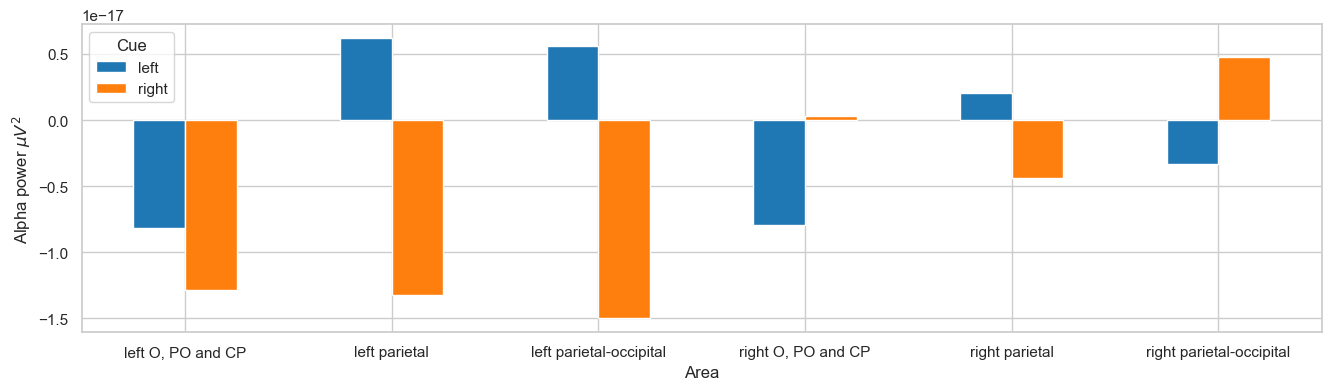

In [190]:
powers_grouped = all_powers.groupby(['ROI', 'Cue'])['Power'].mean().reset_index()

# powers_grouped = powers_grouped[~powers_grouped['ROI'].isin(['left O, PO and CP', 'right O, PO and CP'])]
powers_grouped = powers_grouped[~powers_grouped['ROI'].isin(['left occipital', 'right occipital'])]

powers_pivot = powers_grouped.pivot(index='ROI', columns='Cue', values='Power')
powers_pivot.plot(kind='bar', figsize=(16, 4), color=tab10)

plt.ylabel(r'Alpha power $\mu V^{2}$')
plt.xlabel('Area')
plt.xticks(rotation=0)
plt.show()


### Baselined Powers

In [161]:
tab10 = list(mc.TABLEAU_COLORS.values())

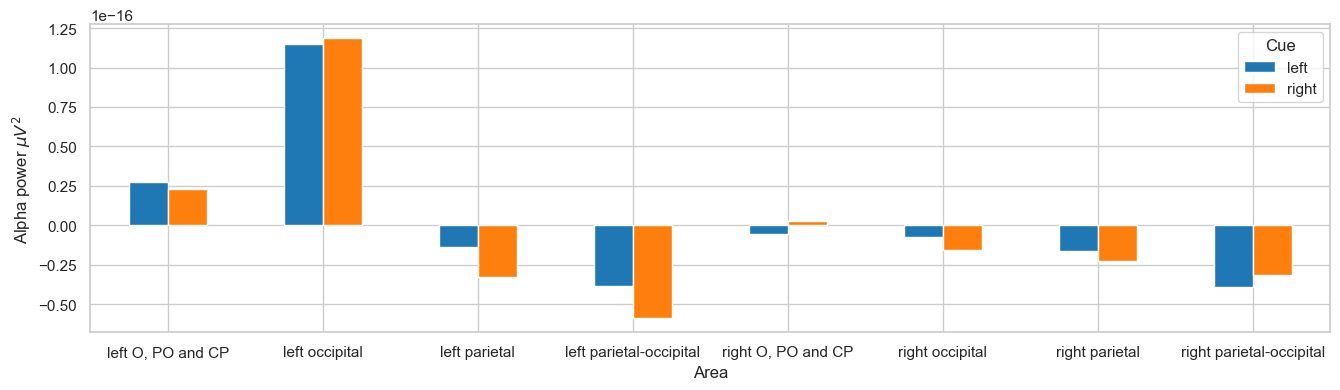

In [191]:
powers_grouped = powers_baselines.groupby(['ROI', 'Cue'])['Baselined Power'].mean().reset_index()

# powers_grouped = powers_grouped[powers_grouped['ROI'].isin(['left O, PO and CP', 'right O, PO and CP'])]

powers_pivot = powers_grouped.pivot(index='ROI', columns='Cue', values='Baselined Power')
powers_pivot.plot(kind='bar', figsize=(16, 4), color=tab10)

plt.ylabel(r'Alpha power $\mu V^{2}$')
plt.xlabel('Area')
plt.xticks(rotation=0)
plt.show()

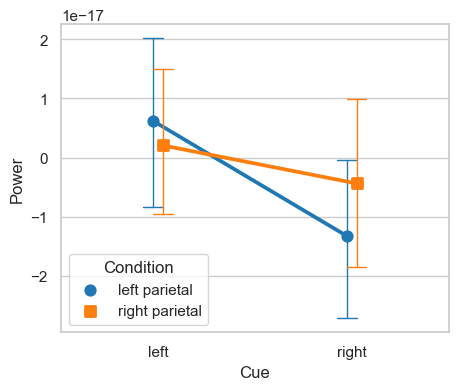

In [198]:
df_o = powers_baselines.copy()
df_o = df_o[df_o['ROI'].isin(['left parietal', 'right parietal'])]
# df_o['ROI'] = df_o['ROI'].replace({'left O, PO and CP': 'Left hemisphere', 'right O, PO and CP': 'Right hemisphere'})

# Interaction plot for session_type and task with respect to key_resp.rt
sns.set(style="whitegrid")
plt.figure(figsize=(5, 4))
interaction_plot = sns.pointplot(x='Cue', y='Power', hue='ROI', data=df_o, dodge=True, markers=['o', 's'], capsize=.1, errwidth=1, palette='tab10')

# plt.xlabel('Session / posner task')
# plt.ylabel('Mean reaction time')
plt.legend(title='Condition')
plt.show()


In [22]:
import scipy.stats as stats

In [196]:
# Get unique ROIs
df = all_powers
unique_rois = df['ROI'].unique()
results = []

for roi in unique_rois:
    # Filter data for specific ROI
    roi_df = df[df['ROI'] == roi]
    
    # Split data based on cue
    left_cue = roi_df[roi_df['Cue'] == 'left']['Power']
    right_cue = roi_df[roi_df['Cue'] == 'right']['Power']
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(left_cue, right_cue)
    
    # Store results
    results.append((roi, t_stat, p_value, left_cue.mean(), right_cue.mean()))

# Convert results into DataFrame for easier visualization
results_df = pd.DataFrame(results, columns=['ROI', 'T-statistic', 'p-value', 'Mean Left', 'Mean Right'])
results_df

,ROI,T-statistic,p-value,Mean Left,Mean Right
0,left occipital,-0.246093,0.805933,9.771930e-18,1.336370e-17
1,right occipital,0.601906,0.548111,8.637104e-19,-7.074043e-18
2,left parietal-occipital,1.885649,0.061201,5.625763e-18,-1.499552e-17
3,right parietal-occipital,-0.683142,0.495530,-3.312310e-18,4.775531e-18
4,left parietal,1.913576,0.057506,6.193649e-18,-1.323784e-17
5,right parietal,0.675736,0.500209,2.065314e-18,-4.356369e-18
6,"right O, PO and CP",-0.862504,0.389734,-7.906201e-18,3.255126e-19
7,"left O, PO and CP",0.445517,0.656564,-8.129160e-18,-1.289422e-17


### Baselined Powerz

In [197]:
# Get unique ROIs
df = powers_baselines
unique_rois = df['ROI'].unique()
results = []

for roi in unique_rois:
    # Filter data for specific ROI
    roi_df = df[df['ROI'] == roi]
    
    # Split data based on cue
    left_cue = roi_df[roi_df['Cue'] == 'left']['Power']
    right_cue = roi_df[roi_df['Cue'] == 'right']['Power']
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(left_cue, right_cue)
    
    # Store results
    results.append((roi, t_stat, p_value, left_cue.mean(), right_cue.mean()))

# Convert results into DataFrame for easier visualization
results_df = pd.DataFrame(results, columns=['ROI', 'T-statistic', 'p-value', 'Mean Left', 'Mean Right'])
results_df

,ROI,T-statistic,p-value,Mean Left,Mean Right
0,left occipital,-0.246093,0.805933,9.771930e-18,1.336370e-17
1,right occipital,0.601906,0.548111,8.637104e-19,-7.074043e-18
2,left parietal-occipital,1.885649,0.061201,5.625763e-18,-1.499552e-17
3,right parietal-occipital,-0.683142,0.495530,-3.312310e-18,4.775531e-18
4,left parietal,1.913576,0.057506,6.193649e-18,-1.323784e-17
5,right parietal,0.675736,0.500209,2.065314e-18,-4.356369e-18
6,"right O, PO and CP",-0.862504,0.389734,-7.906201e-18,3.255126e-19
7,"left O, PO and CP",0.445517,0.656564,-8.129160e-18,-1.289422e-17


In [140]:
len(powers_baselines[powers_baselines['ROI']=='left occipital'])

76